# David Braslow Module 5 Project: LANL Earthquake Prediction

# Abstract

briefly explains your problem, your methodology, and your findings, and business recommendations as a result of your findings. This section should be 1-2 paragraphs long.

## Simulated earthquake experiment

The data are from an experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model.

Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics. 

Los Alamos' initial work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles.   

## Competition 

In this competition, the team has provided a much more challenging dataset with considerably more aperiodic earthquake failures.  
Objective of the competition is to predict the failures for each test set.  

# Initialization

## Load packages

In [1]:
import gc
import os
import time
import logging
import datetime
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal, stats
from scipy.signal import butter, convolve, deconvolve, hann, hilbert
from statsmodels.robust import mad

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

import pywt 
from tsfresh.feature_extraction import feature_calculators

from itertools import product
from tqdm import tqdm_notebook
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")

## Load the data

In [2]:
#Set File Path
IS_LOCAL = True
if(IS_LOCAL):
    PATH="../dsc-5-capstone-project-online-ds-sp-000/LANL-Earthquake-Prediction"
else:
    PATH="../input/"
os.listdir(PATH)

['lgbm_importances.png',
 'sample_submission.csv',
 'submission.csv',
 'test',
 'train.csv']

In [8]:
# Explore Test Folder
print("There are {} files in test folder".format(len(os.listdir(os.path.join(PATH, 'test' )))))

There are 2624 files in test folder


In [9]:
%%time
# Load Train Data
train_df = pd.read_csv(os.path.join(PATH,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

Wall time: 2min 4s


In [10]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [11]:
# Examine some train rows
pd.options.display.precision = 15
train_df.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


## Visualize training data

Plot 0.1% of the data by sampling every 1000 points of data.  

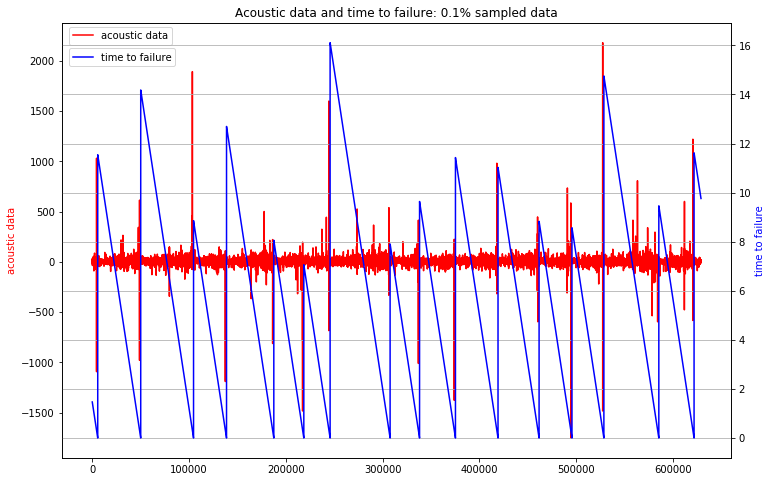

In [12]:
train_ad_sample_df = train_df['acoustic_data'].values[::1000]
train_ttf_sample_df = train_df['time_to_failure'].values[::1000]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 0.1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

Just before each failure there seems to be a large oscillation, but not all large oscillations have a failure following them.

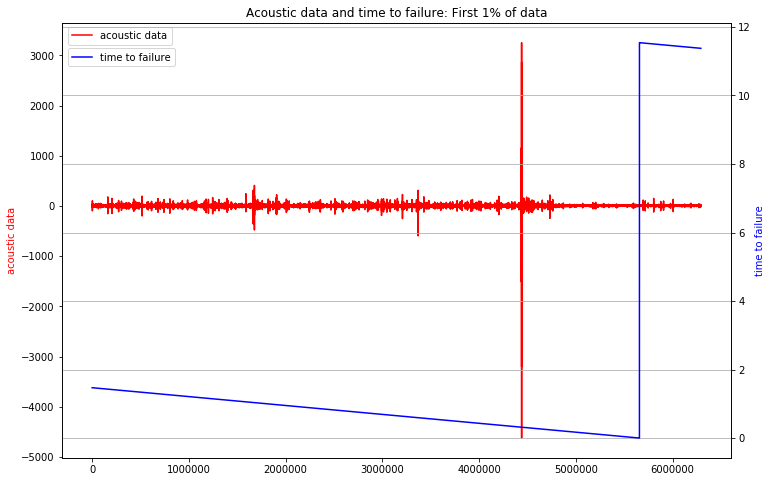

In [13]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: First 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

There seems to be a lag between the time of the large oscilation and the failure.

# Scrubbing the Data

The test segments are 150,000 rows each, and I assume they are independent. I therefore split the train data into segments of the same size. I then calculate a large number of features for each segment. For demonstration purposes, I create only 1000 train samples.

In [14]:
SEGMENT_ROWS = 150000
TRAIN_SEGMENTS = 10000

## Feature Generation

In [15]:
def add_trend_feature(arr):
    idx = np.array(range(len(arr)))
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    ratio = sta / lta   
    ratio = ratio[~np.isnan(ratio)]
    ratio = ratio[~np.isinf(ratio)]
    
    return ratio

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1])
    change = change[~np.isnan(change)]
    change = change[~np.isinf(change)]
    return np.mean(change)

def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold
    sigma = (1/0.6745) * mad(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

In [133]:
class FeatureGenerator(object):
    
    def __init__(self, dtype, n_jobs=1, n_samples=1000, n_cycles = None):
        self.segment_rows = 150000
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        
        self.n_cycles = n_cycles
        self.len_train = 629145480
        
        
        if self.dtype == 'train':
            self.filename = PATH + '/train.csv'
            
            if self.n_cycles:
                self.n_samples = 0
                self.cycle_shift = round(self.segment_rows/self.n_cycles)
                for cycle in range(self.n_cycles):
                    cycle_samples = np.floor((self.len_train - cycle * self.cycle_shift)/self.segment_rows).astype(int)
                    self.n_samples += cycle_samples
            else:
                self.n_samples = n_samples
                
        else:
            submission = pd.read_csv(PATH + '/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, PATH + '/test/' + seg_id + '.csv'))
            self.n_samples = len(submission.seg_id.values)
    
    # Define generator to provide acoustic data chunks
    def read_chunks(self):
        if self.dtype == 'train':
#             total_rows = train_df.shape[0]
#             scaling_factor = ((total_rows - self.segment_rows) / (self.n_samples - 1))
#             seg_inds = np.round(np.array(range(0, self.n_samples)) * scaling_factor).astype(int)
            
            iterator_df = pd.read_csv(PATH + '/train.csv', skiprows = 1, iterator=True, chunksize=150000, header=None, 
                      names = ['acoustic_data', 'time_to_failure'],  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            train_data_cycle = 0
    
            for counter in range(self.n_samples):
                try:
                    df = iterator_df.get_chunk()
                except:
                    train_data_cycle += 1
                    iterator_df = pd.read_csv(PATH + '/train.csv', skiprows = 1 + train_data_cycle*50000, iterator=True, chunksize=150000, header=None, 
                          names = ['acoustic_data', 'time_to_failure'],  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
                    df = iterator_df.get_chunk()
                                    
                x = df['acoustic_data'].values
                y = df['time_to_failure'].values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y

        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.segment_rows:]
                del df
                yield seg_id, x, -999
    
    #Call feature function for each of 6 data transformations, collect into one dictionary
    def get_features(self, x, y, seg_id):
        """
        Gets six groups of features: from untransformed, real, and imaginary parts of FFT, from raw and denoised data.
        """
        
        # Untransformed signals - raw and denoised
        raw = x
        ur_dict = self.features(raw, 'ur')
    
        denoised = denoise_signal(x)
        ud_dict = self.features(denoised, 'ud')
        
        # FFT transformed signals - raw and denoised
#         zc_raw = np.fft.fft(raw)
#         realFFT_raw = np.real(zc_raw)
#         imagFFT_raw = np.imag(zc_raw)
        
#         rr_dict = self.features(realFFT_raw, 'rr')
#         ir_dict = self.features(imagFFT_raw, 'ir')

#         zc_den = np.fft.fft(denoised)
#         realFFT_den = np.real(zc_den)
#         imagFFT_den = np.imag(zc_den)
        
#         rd_dict = self.features(realFFT_den, 'rd')
#         id_dict = self.features(imagFFT_den, 'id')
        
#         dict_tuples = zip(['ur', 'rr', 'ir', 'ud', 'rd', 'id'], [ur_dict, rr_dict, ir_dict, ud_dict, rd_dict, id_dict])
        dict_tuples = zip(['ur', 'ud'], [ur_dict, ud_dict])
        main_dict = {}
        
        main_dict['seg_id'] = seg_id   
        main_dict['target'] = y        
        
        for prefix, p_dict in dict_tuples:
            for k, v in p_dict.items():
                    main_dict[f'{prefix}_{k}'] = v
                    
        return main_dict
        
    #Calculate features from data
    def features(self, x, type = None):
        feature_dict = dict()


        # lists with parameters to iterate over them
        percentiles = [5, 10, 25, 50, 75, 90, 95]
        hann_windows = [150, 5000, 15000]
        spans = [50, 150, 500, 1500, 5000, 15000]
        slices = [1000, 3000, 10000, 30000, 50000]
        windows = [10, 30, 100, 300, 1000, 3000, 10000]
        borders = list(range(-4000, 4001, 1000))
        peaks = [10, 20, 50, 100]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        autocorr_lags = [5, 10, 30, 100, 300, 1000, 3000, 10000]
        
        # transforms of X used repeatedly
        abs_x = np.abs(x)
        x_ser = pd.Series(x)
        
        # basic summary stats
        feature_dict['mean'] = np.mean(x)
        # feature_dict['std'] = np.std(x)
        # feature_dict['max'] = np.max(x)
        # feature_dict['min'] = np.min(x)
        # feature_dict['sum'] = np.sum(x)

        # intermediate summary stats
        # feature_dict['mad'] = mad(x)
        feature_dict['kurt'] = stats.kurtosis(x)
        feature_dict['skew'] = stats.skew(x)
        # feature_dict['med'] = np.median(x)
        # feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        
        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        # feature_dict['abs_max'] = np.max(abs_x)
        feature_dict['abs_mean'] = np.mean(abs_x)
        # feature_dict['abs_std'] = np.std(abs_x)

        # Harmonic, Geometric and Hilbert means
        feature_dict['hmean'] = stats.hmean(abs_x[np.nonzero(abs_x)[0]])
        feature_dict['gmean'] = stats.gmean(abs_x[np.nonzero(abs_x)[0]]) 
        # feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()
        
        # K-statistics and moments
#         for i in range(3, 5):
#             feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
#             feature_dict[f'moment_{i}'] = stats.moment(x, i)

#         for i in [1, 2]:
#             feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)
                
        # Range stats
        feature_dict['max_to_min'] = np.max(x) / np.abs(np.min(x))
        feature_dict['max_to_min_diff'] = np.max(x) - np.abs(np.min(x))
        # feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
        
        # Change rates for slices of data
        feature_dict['mean_change_rate'] = calc_change_rate(x)
        
        for slice_length, direction in product([1000, 3000, 10000, 30000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])

        # Percentiles on original and absolute values
        if (type != 'ur'):
            feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
            for p in percentiles:
                feature_dict[f'percentile_{p}'] = np.percentile(x, p)
                feature_dict[f'abs_percentile_{p}'] = np.percentile(abs_x, p)
        
        # Trend features
        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(abs_x)

        # STA/LTA Ratios
        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
            
        # Hann windows
        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()     

        # Summary statistics on various slices of data
        for agg_type, slice_length, direction in product([np.std, np.min, np.max, np.mean], slices, ['first', 'last']):
            agg_name = agg_type.__name__
            if direction == 'first':
                feature_dict[f'{agg_name}_{direction}_{slice_length}'] = agg_type(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'{agg_name}_{direction}_{slice_length}'] = agg_type(x[-slice_length:])

        # Statistics on rolling windows of various sizes
        for w in windows:
            x_roll_std = x_ser.rolling(w).std().dropna().values
            x_roll_mean = x_ser.rolling(w).mean().dropna().values

            # feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
            # feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
            # feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
            feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)

            feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
            # feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            # feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

            feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
            feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
            feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
            feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

            feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
            # feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()
            
        # Exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x_ser, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x_ser, span=s).mean(skipna=True)).std(skipna=True)
            # feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x_ser, span=s).std(skipna=True)).mean(skipna=True)
            # feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x_ser, span=s).std(skipna=True)).std(skipna=True)
        
        # Counts of large amplitudes
        feature_dict['count_big'] = len(x[np.abs(x) > 500])

        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()
        
        # Time Series Features from tsfresh
#         feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
#         feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
#         feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
#         feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
#         feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
#         feature_dict['mean_change'] = feature_calculators.mean_change(x)
#         feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
#         feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
#         feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

#         for i, j in zip(borders, borders[1:]):
#             feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)

#         feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
#         feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
#         feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
#         feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
#         feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

#         for lag in lags:
#             feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
#         for autocorr_lag in autocorr_lags:
#             feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
#             feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

#         for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
#             feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

#         feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
#         feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
#         feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
#         feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)

#         for p in percentiles:
#             feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

#         feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)

#         for peak in peaks:
#             feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)

#         for c in coefs:
#             feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
#             feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  

        # Return dictionary with all features   
        return feature_dict

    def generate(self):
        dict_list = []
        res = Parallel(n_jobs=self.n_jobs, backend='threading')(delayed(self.get_features)(x, y, s) for s, x, y in tqdm_notebook(self.read_chunks(), total=self.n_samples))
        for r in res:
            dict_list.append(r)

        return pd.DataFrame(dict_list).set_index('seg_id')

In [134]:
training_fg = FeatureGenerator(dtype='train', n_jobs = 3, n_cycles = 3)
training_data = training_fg.generate()
gc.collect()

15264

In [135]:
test_fg = FeatureGenerator(dtype='test', n_jobs=3)
test_data = test_fg.generate()

In [147]:
print(training_data.shape)

(12580, 552)


In [136]:
train_X = training_data.drop('target', axis = 1)
train_y = training_data['target']
test_X = test_data.drop('target', axis = 1)

In [137]:
# Dropping columns with no variance
for col in train_X.columns:
    if train_X[col].std() == 0:
        print(col)
        train_X.drop(col, axis = 1, inplace = True)
        test_X.drop(col, axis = 1, inplace = True)

### Scaling the data

In [138]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [139]:
# Dropping columns with no variance
for col in scaled_train_X.columns:
    if scaled_train_X[col].std() == 0:
        print(col)
        scaled_train_X.drop(col, axis = 1, inplace = True)
        scaled_test_X.drop(col, axis = 1, inplace = True)

## Feature Selection

First, drop features with correlations above 0.99

In [140]:
CORR_LIM = 0.99
largest_corr = 1

while True:
    largest_corr = 0
    largest_col = None
    
    # Calculate correlation matrix
    corr_mat = scaled_train_X.corr().values
    
    # Loop across columns
    for i, col in enumerate(scaled_train_X.columns):
        
        #Get correlations for that columns
        col_corr = corr_mat[i]
        
        #Remove correlation with itself
        col_corr = np.delete(col_corr, i)
        
        #Get maximum correlation with other variables
        max_corr = col_corr.max()
        
        #If this column has a larger correlation, chose it for removal
        if max_corr > largest_corr:
            largest_corr = np.round(max_corr, decimals = 5)
            largest_col = col
            
    #End loop if largest corr is under CORR_LIM
    if largest_corr < CORR_LIM:
        break
        
    #Remove column with highest correlation among columns        
    print(f'Dropping {largest_col}, Max Correlation: {largest_corr}')
    scaled_train_X.drop(largest_col, axis = 1, inplace = True)      
    scaled_test_X.drop(largest_col, axis = 1, inplace = True)      

Dropping ud_Hann_window_mean_150, Max Correlation: 1.0
Dropping ud_Hann_window_mean_5000, Max Correlation: 1.0
Dropping ud_abs_max_roll_mean_1000, Max Correlation: 1.0
Dropping ud_abs_max_roll_mean_10000, Max Correlation: 1.0
Dropping ud_abs_max_roll_mean_3000, Max Correlation: 1.0
Dropping ud_ave_roll_mean_10, Max Correlation: 1.0
Dropping ud_ave_roll_mean_100, Max Correlation: 1.0
Dropping ud_ave_roll_mean_30, Max Correlation: 1.0
Dropping ud_ave_roll_mean_300, Max Correlation: 1.0
Dropping ud_count_big, Max Correlation: 1.0
Dropping ud_count_big_150000_less_threshold_100, Max Correlation: 1.0
Dropping ud_exp_Moving_average_1500_mean, Max Correlation: 1.0
Dropping ud_exp_Moving_average_150_mean, Max Correlation: 1.0
Dropping ud_exp_Moving_average_500_mean, Max Correlation: 1.0
Dropping ud_exp_Moving_average_50_mean, Max Correlation: 1.0
Dropping ur_Hann_window_mean_150, Max Correlation: 1.0
Dropping ur_Hann_window_mean_5000, Max Correlation: 1.0
Dropping ur_abs_max_roll_mean_1000, Ma

Dropping ur_percentile_roll_mean_75_window_10000, Max Correlation: 0.99865
Dropping ur_percentile_roll_mean_25_window_10000, Max Correlation: 0.99865
Dropping ud_av_change_abs_roll_std_100, Max Correlation: 0.99864
Dropping ud_std_roll_mean_1000, Max Correlation: 0.99864
Dropping ud_percentile_roll_mean_50_window_30, Max Correlation: 0.99859
Dropping ur_percentile_roll_std_95_window_30, Max Correlation: 0.99855
Dropping ur_exp_Moving_average_50_std, Max Correlation: 0.99854
Dropping ur_percentile_roll_mean_50_window_30, Max Correlation: 0.99852
Dropping ur_percentile_roll_mean_75_window_3000, Max Correlation: 0.99851
Dropping ur_percentile_roll_mean_50_window_300, Max Correlation: 0.99846
Dropping ur_av_change_abs_roll_std_30, Max Correlation: 0.99843
Dropping ud_percentile_roll_mean_90_window_1000, Max Correlation: 0.99843
Dropping ur_amin_first_3000, Max Correlation: 0.9984
Dropping ur_av_change_abs_roll_std_10000, Max Correlation: 0.99838
Dropping ur_percentile_roll_std_75_window_10

Dropping ur_percentile_roll_mean_95_window_300, Max Correlation: 0.99161
Dropping ud_percentile_roll_mean_25_window_30, Max Correlation: 0.99152
Dropping ud_percentile_roll_mean_95_window_100, Max Correlation: 0.99116
Dropping ur_percentile_roll_mean_5_window_100, Max Correlation: 0.99108
Dropping ud_percentile_roll_mean_75_window_30, Max Correlation: 0.99088
Dropping ur_percentile_roll_std_25_window_10000, Max Correlation: 0.99038
Dropping ur_percentile_roll_std_75_window_1000, Max Correlation: 0.99001


Next, describe the features that remain.

In [141]:
# Count features, by type
print(scaled_train_X.shape)
for tr in ['ur', 'rr', 'ir', 'ud', 'rd', 'id']:
    tr_vars = [x for x in scaled_train_X.columns if x[0:2] == tr]
    n_tr_vars = len(tr_vars)
    print(f'{tr} has {n_tr_vars} variables')

(12580, 288)
ur has 132 variables
rr has 0 variables
ir has 0 variables
ud has 156 variables
rd has 0 variables
id has 0 variables


In [142]:
var_list = {}

# Get list of all column types
for col in training_data.drop('target', axis = 1).columns:
    col_type = col[3:]
    var_list[col_type] = 0

# Get list of preserved column types
for col in scaled_train_X.columns:
    col_type = col[3:]
    var_list[col_type] += 1

col_counts_df = pd.Series(var_list)
print(col_counts_df.sort_values())

Hann_window_mean_150                    0
ave_roll_mean_1000                      0
ave_roll_mean_100                       0
ave_roll_mean_10                        0
percentile_roll_mean_25_window_300      0
exp_Moving_average_150_mean             0
exp_Moving_average_150_std              0
ave_roll_mean_10000                     0
exp_Moving_average_5000_mean            0
percentile_roll_std_5_window_30         0
exp_Moving_average_50_mean              0
exp_Moving_average_50_std               0
percentile_roll_mean_25_window_1000     0
percentile_roll_mean_75_window_100      0
percentile_roll_mean_25_window_100      0
exp_Moving_average_500_mean             0
ave_roll_mean_30                        0
ave_roll_mean_300                       0
ave_roll_mean_3000                      0
percentile_roll_mean_75_window_300      0
percentile_roll_mean_75_window_3000     0
percentile_roll_mean_5_window_300       0
percentile_roll_mean_90_window_1000     0
percentile_roll_mean_90_window_300

In [143]:
col_counts_df[col_counts_df == 0]

Hann_window_mean_150                    0
Hann_window_mean_15000                  0
Hann_window_mean_5000                   0
abs_max_roll_mean_100                   0
abs_max_roll_mean_1000                  0
abs_max_roll_mean_10000                 0
abs_max_roll_mean_30                    0
abs_max_roll_mean_3000                  0
abs_percentile_90                       0
abs_percentile_95                       0
ave_roll_mean_10                        0
ave_roll_mean_100                       0
ave_roll_mean_1000                      0
ave_roll_mean_10000                     0
ave_roll_mean_30                        0
ave_roll_mean_300                       0
ave_roll_mean_3000                      0
exp_Moving_average_15000_mean           0
exp_Moving_average_1500_mean            0
exp_Moving_average_150_mean             0
exp_Moving_average_150_std              0
exp_Moving_average_5000_mean            0
exp_Moving_average_500_mean             0
exp_Moving_average_50_mean        

In [144]:
scaled_train_X.head()

,ud_abs_max_roll_mean_10,ud_abs_max_roll_mean_300,ud_abs_mean,ud_abs_percentile_10,ud_abs_percentile_25,ud_abs_percentile_5,ud_abs_percentile_50,ud_abs_percentile_75,ud_abs_trend,ud_amax_first_10000,...,ur_std_first_10000,ur_std_first_3000,ur_std_first_50000,ur_std_last_10000,ur_std_last_3000,ur_std_last_30000,ur_std_last_50000,ur_std_roll_mean_1000,ur_std_roll_mean_10000,ur_trend
0,-0.197656029891308,-0.064427983112627,0.034174013353746,0.063513651226387,1.068699372057777,-0.411655246003022,1.370505458227036,0.574024285383833,-0.390503484085359,0.750003274218522,...,0.738002068752139,1.173796740870266,0.037986972151333,-0.142156248525463,-0.221831161756495,-0.231240300802902,-0.283120305961828,0.268790627967401,1.935325214250778,-1.764341778974555
1,0.153431124697462,0.091527728782781,0.121589757376861,-0.033007508775956,0.821537835418855,-0.482549255001560,0.721461590665400,0.217734918864724,-0.170054084516285,-0.320198548181607,...,-0.199128556698111,-0.235852891583483,0.130859534004380,-0.226966255640102,-0.335061192800033,-0.016605833844072,-0.075195345527127,-0.141042209405285,-1.004766615997837,0.488196132447382
2,-0.076042027281197,0.021452372710506,0.408243668814709,-0.253996763921863,1.263893282475706,-0.555443448158589,1.525373203792681,0.587639826404579,0.341729076817320,0.575869801236654,...,0.381259730799576,-0.153751870190149,-0.005648968327805,0.485505716795145,-0.307901314912401,0.485589293432969,0.278542402879256,0.085354512003196,0.863421820009263,2.134532830001319
3,0.111787598247028,0.103649285897151,0.269065257897681,-0.010242445156600,1.066613855625870,-0.439381020383771,1.532741091835030,0.574190147010820,-0.068432020744087,0.293386616057418,...,0.175369429311799,-0.190005550410342,0.009506777354780,-0.141786516669513,-0.311820809998608,-0.026638872455034,-0.057071760084576,0.083360857161221,0.322426169949424,0.880842619542917
4,-0.017777064207361,0.047297837534813,0.398215481168672,0.292371315119812,1.608352226209366,-0.328018751200984,1.418813318863984,0.471102185851774,0.161847505970035,0.037574155349416,...,-0.045172435159827,0.308925245165672,-0.094464714536766,0.719191377600325,0.113902280013227,0.164232278458447,0.175150109947836,-0.163933943534035,-0.644891976374960,-0.361562632575097


In [145]:
submission = pd.read_csv(PATH + '/sample_submission.csv', index_col='seg_id')
scaled_test_X = scaled_test_X.set_index(submission.index)
scaled_test_X.head()

,ud_abs_max_roll_mean_10,ud_abs_max_roll_mean_300,ud_abs_mean,ud_abs_percentile_10,ud_abs_percentile_25,ud_abs_percentile_5,ud_abs_percentile_50,ud_abs_percentile_75,ud_abs_trend,ud_amax_first_10000,...,ur_std_first_10000,ur_std_first_3000,ur_std_first_50000,ur_std_last_10000,ur_std_last_3000,ur_std_last_30000,ur_std_last_50000,ur_std_roll_mean_1000,ur_std_roll_mean_10000,ur_trend
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,-0.093700343012927,-0.066667707922299,-0.238913994043801,-0.526124857049369,-0.372648851711682,-0.641147891469526,-0.094773830600956,-0.218564590963999,-0.022160583009630,-0.061949974224755,...,-0.037103875529642,0.328308547585511,-0.091437327850440,0.060552677941983,-0.201292360626130,-0.052917782972139,-0.154707216437152,-0.139097597558439,-0.427938396301917,-0.135548322031947
seg_0012b5,-0.060697019171367,-0.119945107504822,-0.272608876654952,-0.484951177993302,-1.302812134555297,-0.647308031310983,-1.161879087104169,-0.743237102254646,-0.063187710469860,-0.446068158012732,...,-0.257906265016075,-0.143225545739365,0.010803848437046,-0.234639058887684,-0.336872490675259,-0.188166312994347,-0.228205438227823,-0.145343503346892,-0.390131795235762,1.081334611878472
seg_00184e,0.437190163005415,0.244232092032261,0.036461064333646,0.531916267113239,0.330770993129322,-0.149608530021836,0.377942968813476,0.028513053720329,-0.266727614592857,-0.073491101940210,...,-0.202580257792965,0.018861797706887,0.413821064298815,-0.300931196441287,-0.320289623549827,-0.109878880795467,-0.105576223079880,-0.041136677257599,-0.140503342709430,0.190929026871488
seg_003339,-0.223397610797608,-0.173468690293748,-0.346085482405827,1.143542108752094,0.226830238556212,1.560595813530063,-0.066403081364172,-0.202345370061288,-0.057274234433522,-0.232557339748653,...,-0.195949832056404,-0.043234607384903,-0.283209782679021,-0.336624193271613,-0.368523244076217,-0.249123110543976,-0.304024571393820,-0.183719976415959,0.033579688841497,-0.100421971524693
seg_0042cc,-0.013822530409006,-0.123429664907973,-0.343345259505966,-0.184897405286207,-1.543355285295352,-0.406840563694130,-1.446580499599912,-0.704967921685086,0.094648920503589,0.001074775374365,...,-0.038693975600375,-0.233811375857617,-0.094771384129170,0.164764339777809,-0.367638461819084,-0.082059268086041,0.151455143688656,0.130176951291517,0.188577396270250,-0.841278669581314


In [146]:
scaled_train_X.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_train_X_051719_v2.pkl")
train_y.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_y_051719_v2.pkl")
scaled_test_X.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_test_X_051719_v2.pkl")


# Model the Data

Due to the large number of features, I choose to use tree-based approaches for this problem. I will start with a dummy regressor, then move on to a simple random forest, and then to gradient boosted methods. I use 3-fold cross-validation for my models to prevent overfitting.

In [2]:
scaled_train_X = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_train_X_051719_v2.pkl")
train_y = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_y_051719_v2.pkl")
scaled_test_X = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_test_X_051719_v2.pkl")

## Create Hold-Out Set

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train_X, train_y, test_size = 0.2, random_state = 123)

## Dummy

In [5]:
from sklearn.dummy import DummyRegressor

In [6]:
dum_reg = DummyRegressor()
dum_reg.fit(X_train, y_train)

dum_reg_train_pred = dum_reg.predict(X_train)
dum_reg_train_score = mean_absolute_error(y_train, dum_reg_train_pred)

dum_reg_test_pred = dum_reg.predict(X_test)
dum_reg_test_score = mean_absolute_error(y_test, dum_reg_test_pred)

print('Dummy Regressor')
print(f'Train MAE: {dum_reg_train_score}, Test MAE: {dum_reg_test_score}')

Dummy Regressor
Train MAE: 3.064902237448251, Test MAE: 2.985975832596246


## Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
rf_params = {'n_estimators': 10,
              'criterion': 'mae', 
              'max_depth': 15,
              'n_jobs': 3, 
              'random_state': 123,
              'verbose': 2,
              'warm_start': True}

rf_reg = RandomForestRegressor(**rf_params)
rf_reg.fit(X_train, y_train)

rf_reg_train_pred = rf_reg.predict(X_train)
rf_reg_train_score = mean_absolute_error(y_train, rf_reg_train_pred)

rf_reg_test_pred = rf_reg.predict(X_test)
rf_reg_test_score = mean_absolute_error(y_test, rf_reg_test_pred)

print('Random Forest Regressor')
print(f'Train MAE: {rf_reg_train_score}, Test MAE: {rf_reg_test_score}')

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 10building tree 2 of 10
building tree 3 of 10

building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


Random Forest Regressor
Train MAE: 1.1669157739140907, Test MAE: 1.9998924436623222


In [9]:
rf_feature_importances = pd.DataFrame()
rf_feature_importances['feature_name'] = pd.Series(X_train.columns)
rf_feature_importances['feature_importance'] = pd.Series(rf_reg.feature_importances_)
rf_feature_importances = rf_feature_importances.sort_values('feature_importance')

In [10]:
rf_feature_importances.head(10)

,feature_name,feature_importance
180,ur_count_big,0.000000
248,ur_percentile_roll_mean_90_window_10,0.000175
53,ud_count_big_50000_threshold_100,0.000220
241,ur_percentile_roll_mean_50_window_10,0.000264
239,ur_percentile_roll_mean_25_window_10,0.000319
235,ur_percentile_roll_mean_10_window_10,0.000336
244,ur_percentile_roll_mean_5_window_30,0.000362
255,ur_percentile_roll_mean_95_window_30,0.000363
240,ur_percentile_roll_mean_25_window_30,0.000462
49,ud_count_big_50000_less_threshold_10,0.000464


In [11]:
rf_feature_importances.tail(10)

,feature_name,feature_importance
68,ud_max_to_min_diff,0.004576
229,ur_min_roll_std_100,0.004646
231,ur_min_roll_std_10000,0.004674
126,ud_percentile_roll_std_25_window_3000,0.004689
91,ud_min_roll_std_10000,0.004710
123,ud_percentile_roll_std_25_window_10000,0.004825
232,ur_min_roll_std_30,0.005395
205,ur_max_to_min,0.005653
268,ur_percentile_roll_std_5_window_300,0.005952
258,ur_percentile_roll_std_10_window_10000,0.006021


In [16]:
rf_drop_list = list(rf_feature_importances[rf_feature_importances['feature_importance'] < 0.001]['feature_name'].values)
rf_drop_list

['ur_count_big',
 'ur_percentile_roll_mean_90_window_10',
 'ud_count_big_50000_threshold_100',
 'ur_percentile_roll_mean_50_window_10',
 'ur_percentile_roll_mean_25_window_10',
 'ur_percentile_roll_mean_10_window_10',
 'ur_percentile_roll_mean_5_window_30',
 'ur_percentile_roll_mean_95_window_30',
 'ur_percentile_roll_mean_25_window_30',
 'ud_count_big_50000_less_threshold_10',
 'ur_count_big_150000_less_threshold_100',
 'ur_percentile_roll_mean_95_window_100',
 'ur_count_big_100000_threshold_100',
 'ur_percentile_roll_mean_75_window_30',
 'ur_count_big_50000_less_threshold_50',
 'ur_count_big_150000_threshold_100',
 'ud_percentile_75',
 'ud_count_big_100000_less_threshold_100',
 'ur_count_big_50000_threshold_50',
 'ur_percentile_roll_mean_90_window_30',
 'ud_count_big_50000_less_threshold_100',
 'ud_count_big_150000_threshold_20',
 'ur_percentile_roll_mean_10_window_30',
 'ur_percentile_roll_mean_90_window_100',
 'ud_count_big_150000_less_threshold_10',
 'ud_min_roll_std_10',
 'ur_per

In [17]:
X_train_rf = X_train.drop(rf_drop_list, axis = 1)
X_test_rf = X_test.drop(rf_drop_list, axis = 1)

In [ ]:
rf2_params = {'n_estimators': 100,
              'criterion': 'mae', 
              'max_depth': 15,
              'n_jobs': 7, 
              'random_state': 123,
              'verbose': 2,
              'warm_start': True}

rf2_reg = RandomForestRegressor(**rf2_params)
rf2_reg.fit(X_train_rf, y_train)

rf2_reg_train_pred = rf2_reg.predict(X_train_rf)
rf2_reg_train_score = mean_absolute_error(y_train, rf2_reg_train_pred)

rf2_reg_test_pred = rf2_reg.predict(X_test_rf)
rf2_reg_test_score = mean_absolute_error(y_test, rf2_reg_test_pred)

print('Random Forest Regressor v2')
print(f'Train MAE: {rf2_reg_train_score}, Test MAE: {rf2_reg_test_score}')

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


In [ ]:
rf2_feature_importances = pd.DataFrame()
rf2_feature_importances['feature_name'] = pd.Series(X_train.columns)
rf2_feature_importances['feature_importance'] = pd.Series(rf2_reg.feature_importances_)
rf2_feature_importances = rf2_feature_importances.sort_values('feature_importance')

## LightGBM

In [79]:
import lightgbm as lgb

In [80]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [30]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

We run the model. During training for each fold, we validate using the validation set and also we predict using the current model for test set. The final result will be the average over the all folds for the predictions done at each fold training.

In [88]:
lgbm_params = {'n_estimators': 100,
               'objective': 'regression_l1', 
               'metric': 'mae',
               'n_jobs': 3, 
               'random_state': 123,
               'verbosity': -1}

lgbm_reg = lgb.LGBMRegressor(**lgbm_params)
lgbm_reg.fit(X_train, y_train)

lgbm_reg_train_pred = lgbm_reg.predict(X_train)
lgbm_reg_train_score = mean_absolute_error(y_train, lgbm_reg_train_pred)

lgbm_reg_test_pred = lgbm_reg.predict(X_test)
lgbm_reg_test_score = mean_absolute_error(y_test, lgbm_reg_test_pred)

print('Light GBM Regressor')
print(f'Train MAE: {lgbm_reg_train_score}, Test MAE: {lgbm_reg_test_score}')

Light GBM Regressor
Train MAE: 1.5384500712543354, Test MAE: 2.0185446340713455


In [91]:
lgbm_params = {'n_estimators': 1000,
               'objective': 'regression_l1', 
               'metric': 'mae',
               'n_jobs': 3, 
               'random_state': 123,
               'verbosity': -1}

lgbm_reg = lgb.LGBMRegressor(**lgbm_params)
lgbm_reg.fit(X_train, 
             y_train,
             eval_set=[(X_train, y_train), (X_test, y_test)], 
             eval_metric='mae',
             verbose=1, 
             early_stopping_rounds=100
            )

lgbm_reg_train_pred = lgbm_reg.predict(X_train)
lgbm_reg_train_score = mean_absolute_error(y_train, lgbm_reg_train_pred)

lgbm_reg_test_pred = lgbm_reg.predict(X_test)
lgbm_reg_test_score = mean_absolute_error(y_test, lgbm_reg_test_pred)

print('Light GBM Regressor with Early Stopping')
print(f'Train MAE: {lgbm_reg_train_score}, Test MAE: {lgbm_reg_test_score}')

[1]	training's l1: 2.88168	valid_1's l1: 2.805
Training until validation scores don't improve for 100 rounds.
[2]	training's l1: 2.73088	valid_1's l1: 2.66701
[3]	training's l1: 2.60004	valid_1's l1: 2.54839
[4]	training's l1: 2.48928	valid_1's l1: 2.45152
[5]	training's l1: 2.39443	valid_1's l1: 2.3698
[6]	training's l1: 2.31002	valid_1's l1: 2.30329
[7]	training's l1: 2.23957	valid_1's l1: 2.24725
[8]	training's l1: 2.18261	valid_1's l1: 2.20483
[9]	training's l1: 2.13241	valid_1's l1: 2.16895
[10]	training's l1: 2.09062	valid_1's l1: 2.14092
[11]	training's l1: 2.05599	valid_1's l1: 2.11784
[12]	training's l1: 2.0262	valid_1's l1: 2.09866
[13]	training's l1: 1.9997	valid_1's l1: 2.08371
[14]	training's l1: 1.97832	valid_1's l1: 2.07538
[15]	training's l1: 1.95788	valid_1's l1: 2.06658
[16]	training's l1: 1.9385	valid_1's l1: 2.06066
[17]	training's l1: 1.92447	valid_1's l1: 2.05383
[18]	training's l1: 1.90935	valid_1's l1: 2.04769
[19]	training's l1: 1.89341	valid_1's l1: 2.04465
[2

In [109]:
lgbm_params = {'n_estimators': 1000,
               'objective': 'regression_l1', 
               'metric': 'mae',
               'num_leaves': 30,
               'min_data_in_leaf': 10, 
               'objective':'regression',
               'learning_rate': 0.01,
               "feature_fraction": 0.9,
               "bagging_freq": 1,
               "bagging_fraction": 0.9,
               "bagging_seed": 42,
               'n_jobs': 3, 
               'random_state': 123,
               'verbosity': 1}

dtrain_lgb = lgb.Dataset(X_train, label=y_train)
cv_result_lgb = lgb.cv(lgbm_params, 
                       dtrain_lgb, 
                       num_boost_round = 1000, 
                       nfold = 5, 
                       metrics = 'mae',
                       early_stopping_rounds = 100, 
                       verbose_eval = 100, 
                       show_stdv = True,
                       stratified = False)
num_boost_rounds_lgb = len(cv_result_lgb['l1-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))

lgbm_reg = lgb.train(lgbm_params, dtrain_lgb, num_boost_round=num_boost_rounds_lgb)

lgbm_reg_train_pred = lgbm_reg.predict(X_train)
lgbm_reg_train_score = mean_absolute_error(y_train, lgbm_reg_train_pred)

lgbm_reg_test_pred = lgbm_reg.predict(X_test)
lgbm_reg_test_score = mean_absolute_error(y_test, lgbm_reg_test_pred)

print('Light GBM Regressor with Cross-Validated Early Stopping')
print(f'Train MAE: {lgbm_reg_train_score}, Test MAE: {lgbm_reg_test_score}')

[100]	cv_agg's l1: 2.25684 + 0.0484896
[200]	cv_agg's l1: 2.10051 + 0.0444377
[300]	cv_agg's l1: 2.06699 + 0.0411071
[400]	cv_agg's l1: 2.05613 + 0.0389102
[500]	cv_agg's l1: 2.05311 + 0.0377659
[600]	cv_agg's l1: 2.0524 + 0.0371284
[700]	cv_agg's l1: 2.05155 + 0.0366651
[800]	cv_agg's l1: 2.05095 + 0.0368155
[900]	cv_agg's l1: 2.05148 + 0.0359134
num_boost_rounds_lgb=847
Light GBM Regressor with Cross-Validated Early Stopping
Train MAE: 1.378481175484394, Test MAE: 2.0335068699035452


In [111]:
lgbm_params = {'n_estimators': 5000,
               'objective': 'regression_l1', 
               'metric': 'mae',
               'num_leaves': 30,
               'min_data_in_leaf': 10, 
               'objective':'regression',
               'learning_rate': 0.01,
               "feature_fraction": 0.9,
               "bagging_freq": 1,
               "bagging_fraction": 0.9,
               "bagging_seed": 42,
               'n_jobs': 3, 
               'random_state': 123,
               'verbosity': 1}

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    print("fold {}".format(fold_num))
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**lgbm_params)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=200, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_num + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[100]	training's l1: 2.16052	valid_1's l1: 2.22451
[200]	training's l1: 1.92234	valid_1's l1: 2.08734
[300]	training's l1: 1.81145	valid_1's l1: 2.05818
[400]	training's l1: 1.72852	valid_1's l1: 2.04796
[500]	training's l1: 1.6585	valid_1's l1: 2.04417
[600]	training's l1: 1.59514	valid_1's l1: 2.04121
[700]	training's l1: 1.53769	valid_1's l1: 2.04204
[800]	training's l1: 1.48338	valid_1's l1: 2.03994
[900]	training's l1: 1.43117	valid_1's l1: 2.04045
[1000]	training's l1: 1.3819	valid_1's l1: 2.03913
[1100]	training's l1: 1.33538	valid_1's l1: 2.03789
[1200]	training's l1: 1.29046	valid_1's l1: 2.03822
[1300]	training's l1: 1.24759	valid_1's l1: 2.03902
[1400]	training's l1: 1.20551	valid_1's l1: 2.03727
[1500]	training's l1: 1.16528	valid_1's l1: 2.03803
[1600]	training's l1: 1.12657	valid_1's l1: 2.03748
[1700]	training's l1: 1.08989	valid_1's l1: 2.03944
[1800]	training's l1: 1.05431	valid_1's l1: 2.03953
[1900

## Features importance

Let's print features importance.

In [126]:
cols.head()

,importance
Feature,
ud_percentile_90,786.399999999999977
ud_classic_sta_lta7_mean,785.799999999999955
ur_mean_change_rate,780.600000000000023
ud_mean_change_rate_first_1000,778.399999999999977
ud_classic_sta_lta6_mean,746.600000000000023


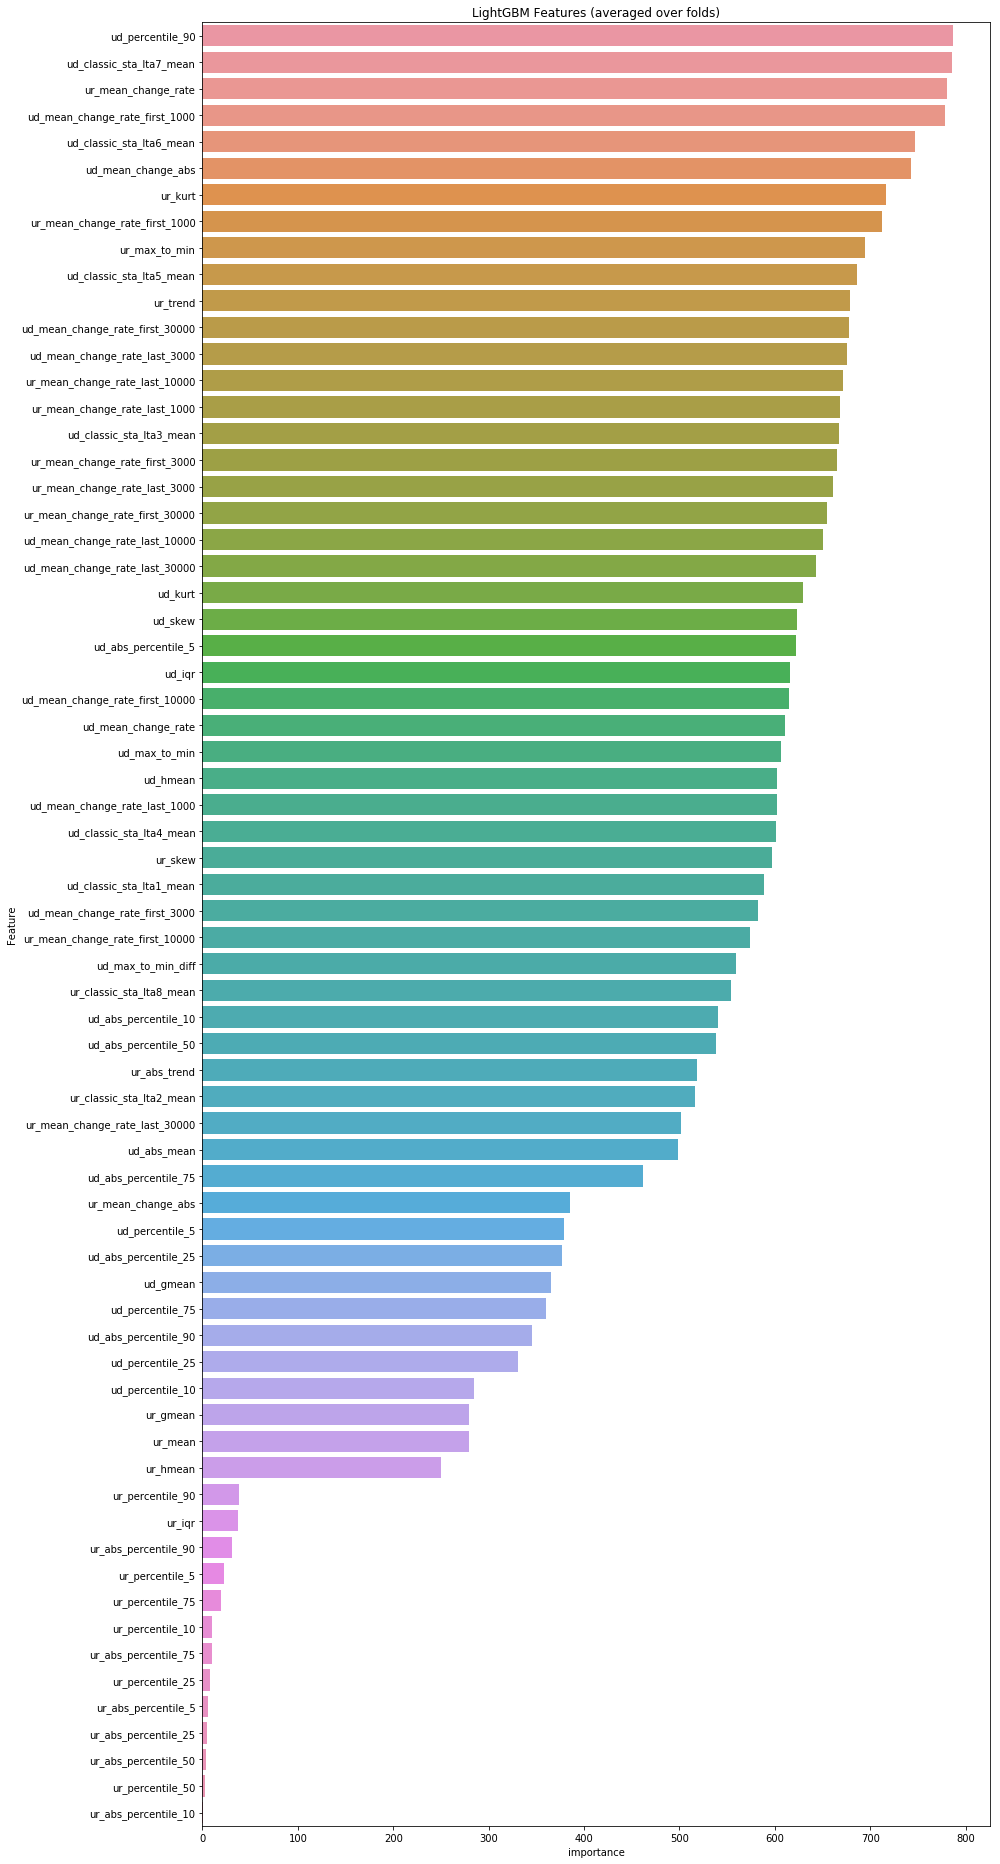

In [131]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200]
        .reset_index())

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=cols)
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig(PATH + '/lgbm_importances.png')

# <a id='6'>Submission</a>  

We set the predicted time to failure in the submission file.

In [132]:
submission.time_to_failure = predictions
submission.to_csv(PATH + '/submission.csv',index=True)

# <a id='7'>References</a>  

[1] Fast Fourier Transform, https://en.wikipedia.org/wiki/Fast_Fourier_transform   
[2] Shifting aperture, in Neural network for inverse mapping in eddy current testing, https://www.researchgate.net/publication/3839126_Neural_network_for_inverse_mapping_in_eddy_current_testing   
[3] Andrews Script plus a Genetic Program Model, https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model/